# Import libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import os
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy import stats
# from create_dataset.CreateDataset import CreateDataset
# from util.VisualizeDataset import VisualizeDataset
from util import util
from sklearn.mixture import GaussianMixture
from scipy.signal import buttord, butter, lfilter, filtfilt
from sklearn.decomposition import PCA, FastICA

### Step 1: Create Dataset
* Aggregate the data with average value each 100 miliseconds
* Set labels 1 (for left) or 2 (for right) or 3 (relaxing).\
As the person is looking at the bottle at the left side and think about taking it; then the person is doing the same withe right hand & sometimes he/she sit staring straight in front ;)

#### Set pathes

In [2]:
FOLDER_PATH = Path('./datasets/motor_imagery/')
RESULT_PATH = Path('./intermediate_datafiles/motor_imagery/step1_result/')
RESULT_PATH.mkdir(exist_ok=True, parents=True)
GRANULARITY = 100 # milisecond per instance; we settle at 100 ms.

#### See an example

In [6]:
def plot_data_eeg(df):
    ### Visualization
    deltas, betas, gammas, alphas, thetas = [], [], [], [], []
    for i in df.columns:
        if i.startswith('Delta'):
            deltas.append(i)
        elif i.startswith('Beta'):
            betas.append(i)
        elif i.startswith('Gamma'):
            gammas.append(i)
        elif i.startswith('Alpha'):
            alphas.append(i)
        elif i.startswith('Theta'):
            thetas.append(i)
            
    plt.rcParams["figure.figsize"] = (20,3)
    plt.rcParams['figure.dpi'] = 100

    def plot_eeg(wave_type_lst, waves_name):
        df.set_index(df.index)[wave_type_lst].plot()
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('Time [sec]')
        plt.ylabel('Voltage [m*V]')
        if waves_name == 'Labels':
            plt.title(f'{waves_name} aggregated by 100 miliseconds')
        else:
            plt.title(f'{waves_name} waves aggregated by 100 miliseconds')
        plt.show();

    def plot_labels(df):
        df.plot(x='left', y='right')
        plt.show();

    plot_eeg(alphas, 'Alpha')
    plot_eeg(betas, 'Beta')
    plot_eeg(gammas, 'Gamma')
    plot_eeg(thetas, 'Theta')
    plot_eeg(deltas, 'Delta')
    plot_eeg(['left', 'right'], 'Labels')

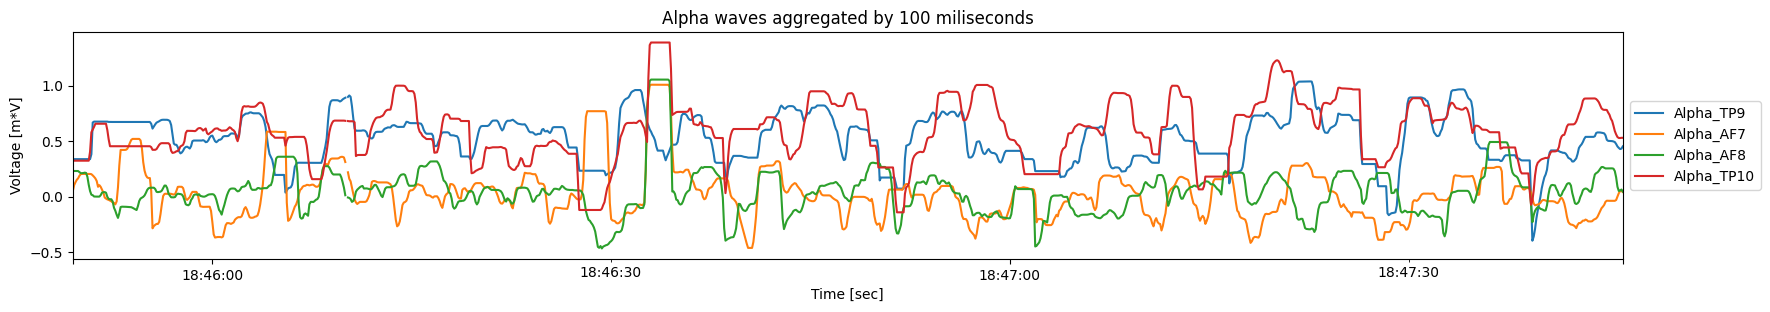

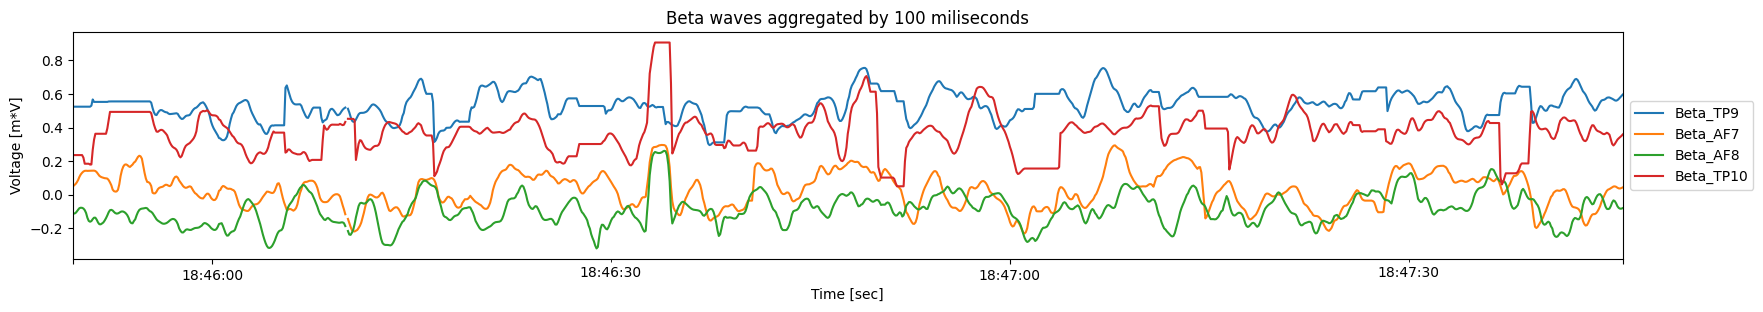

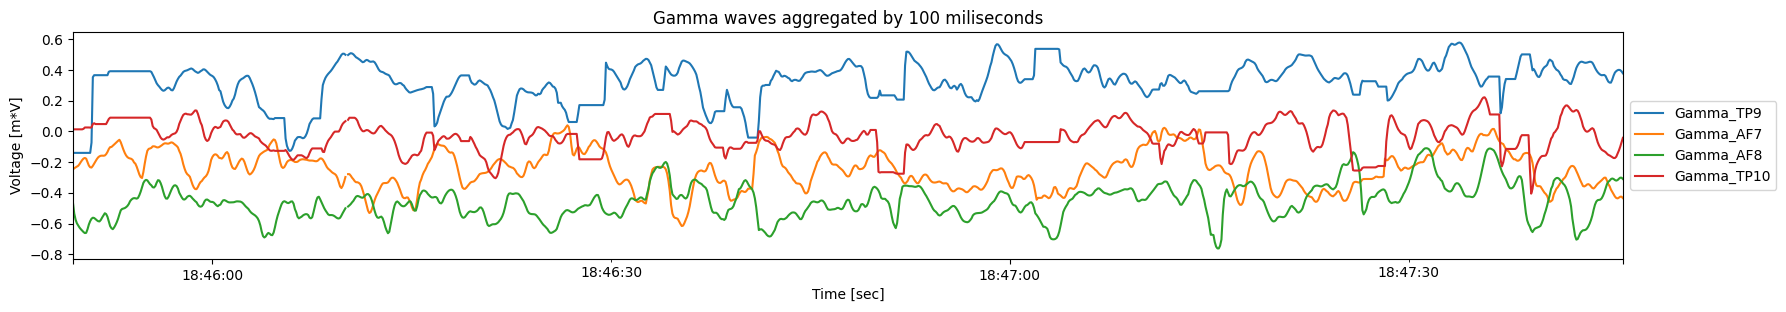

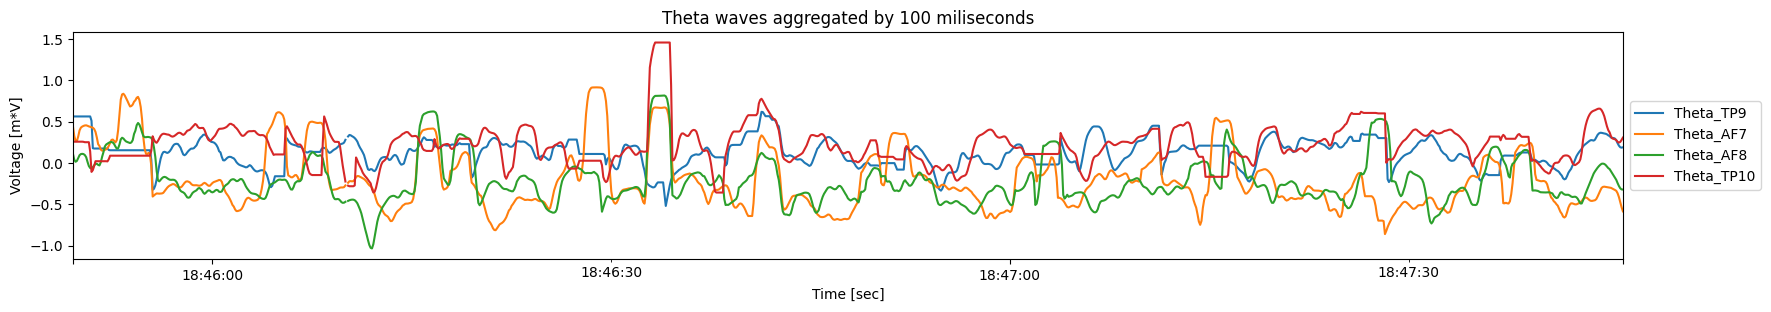

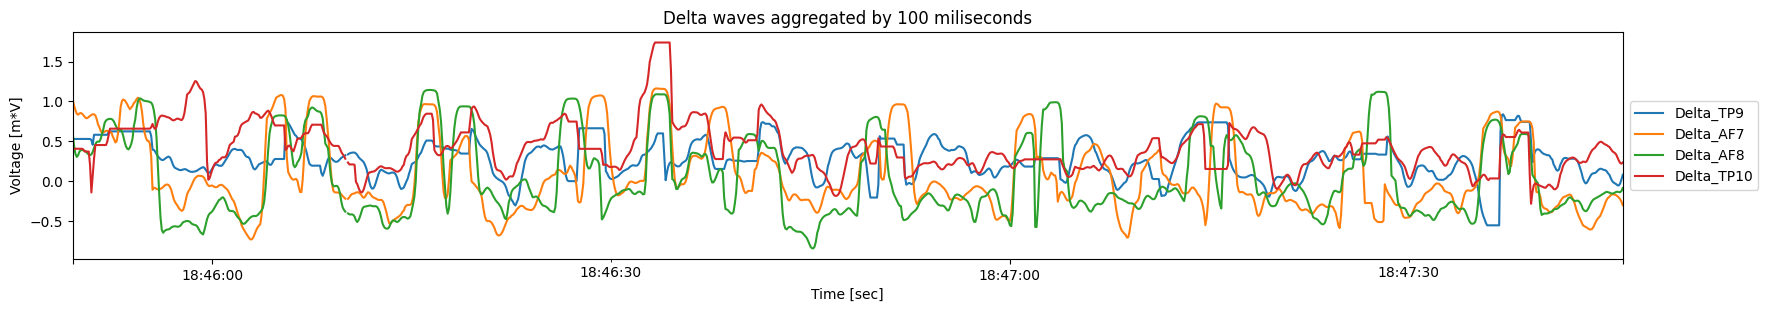

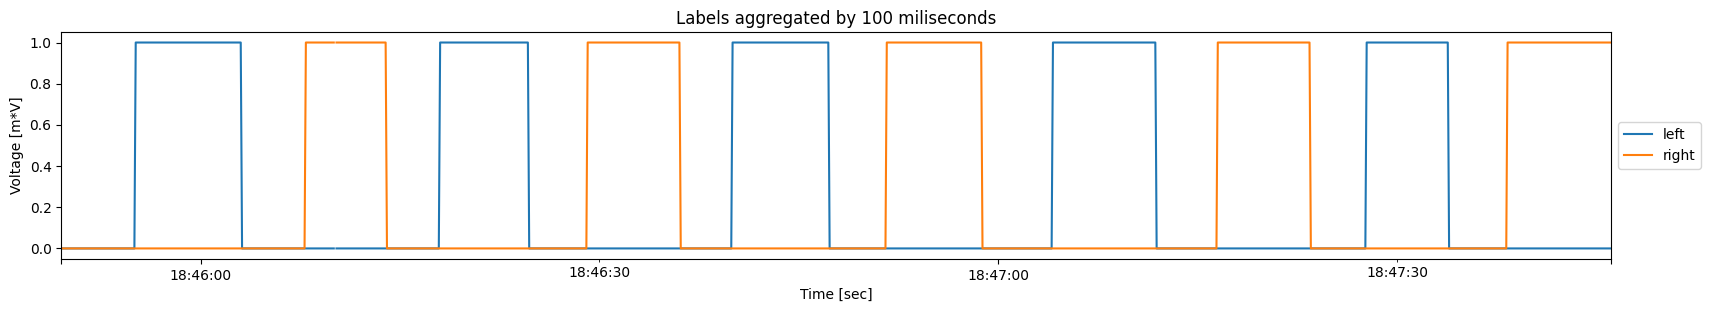

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--18-45-49_174012250194033688.csv


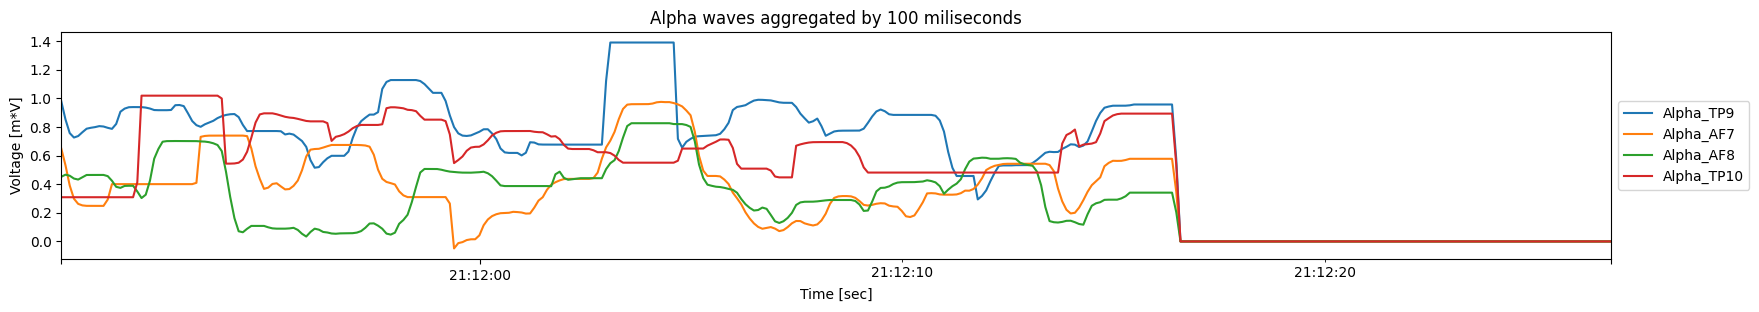

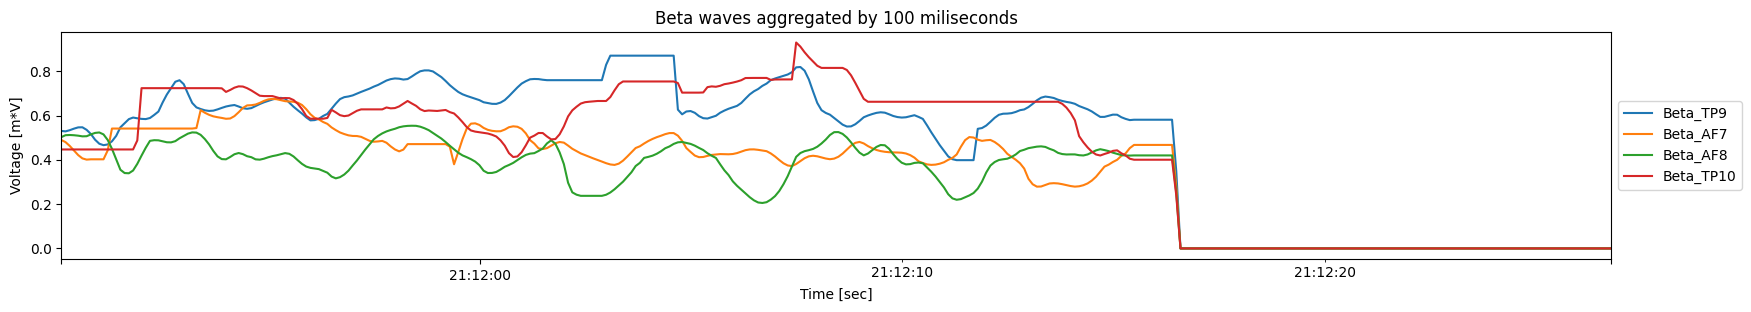

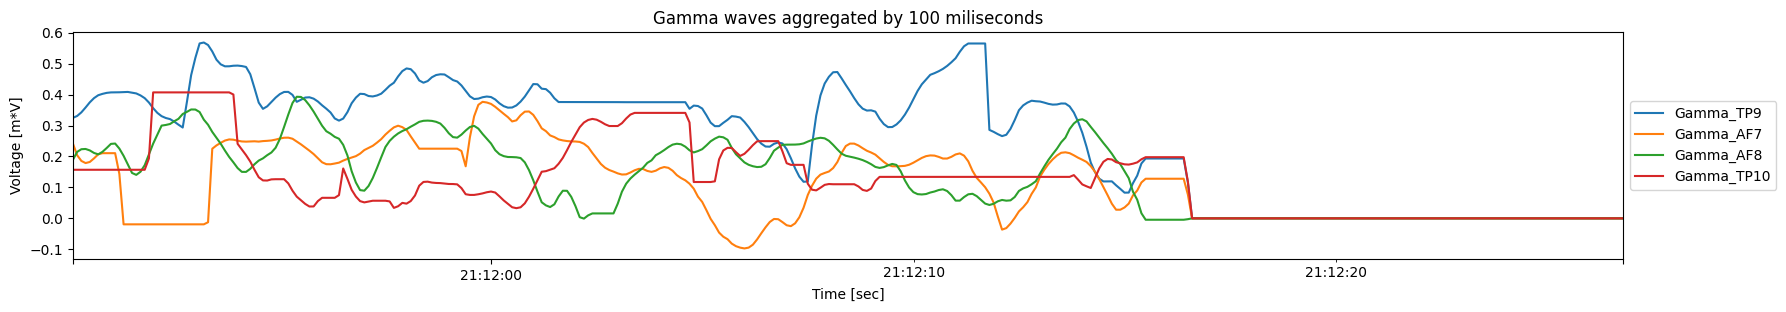

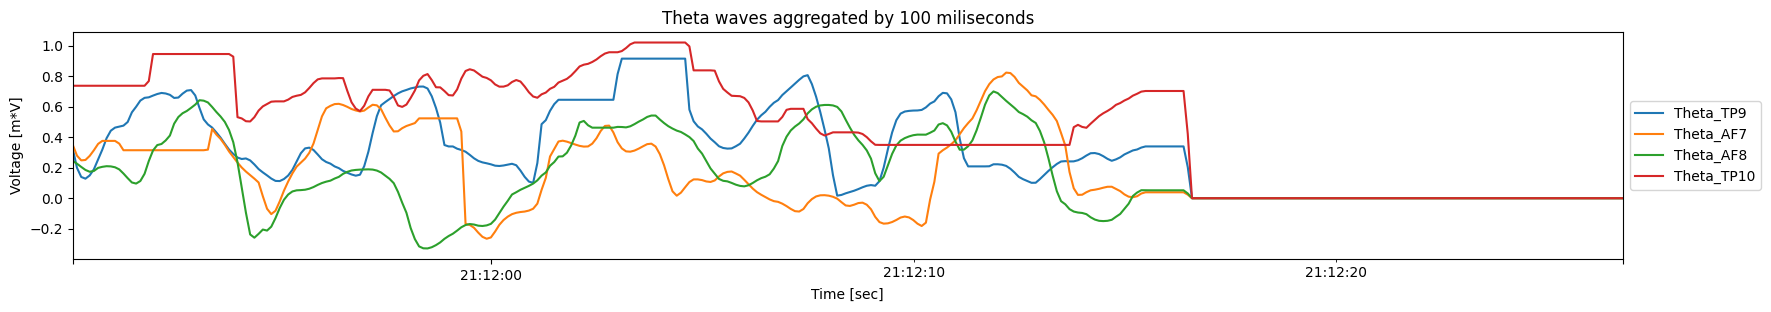

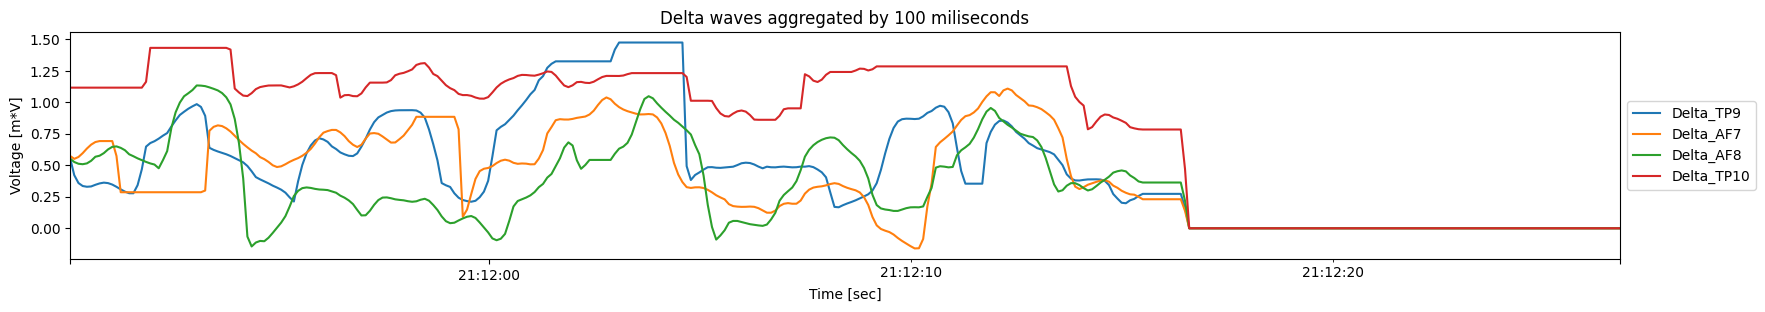

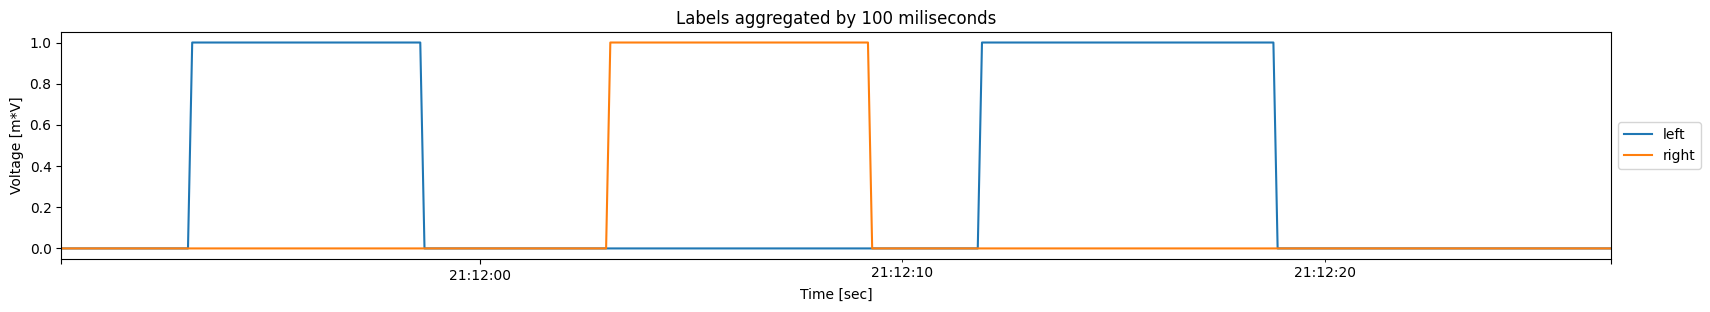

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--21-11-50_6232541803114330650.csv


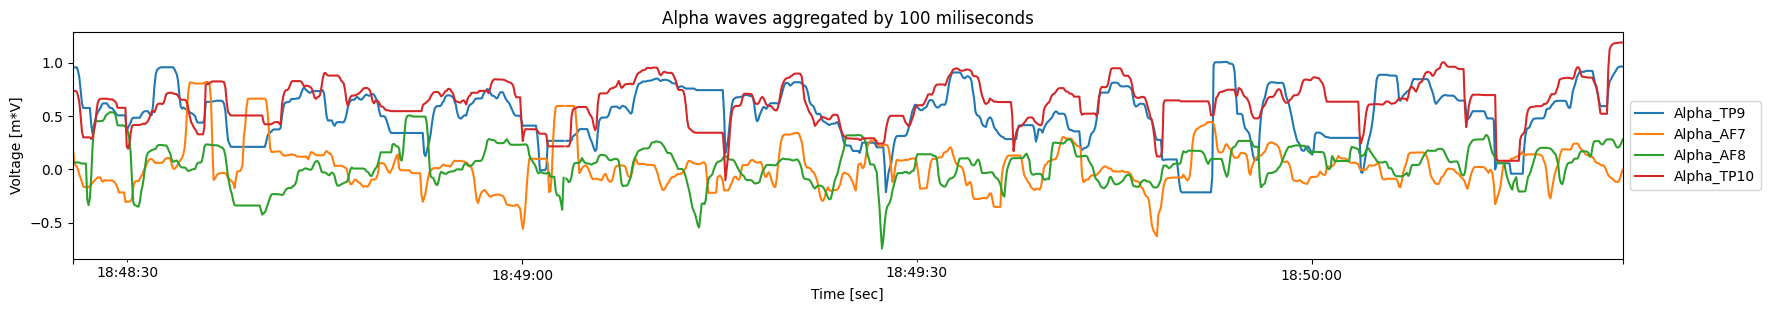

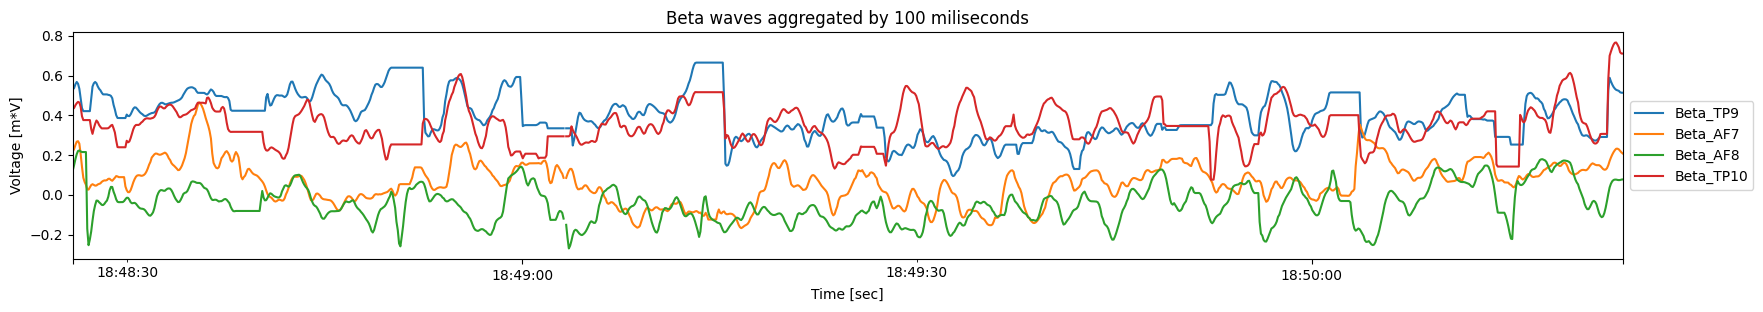

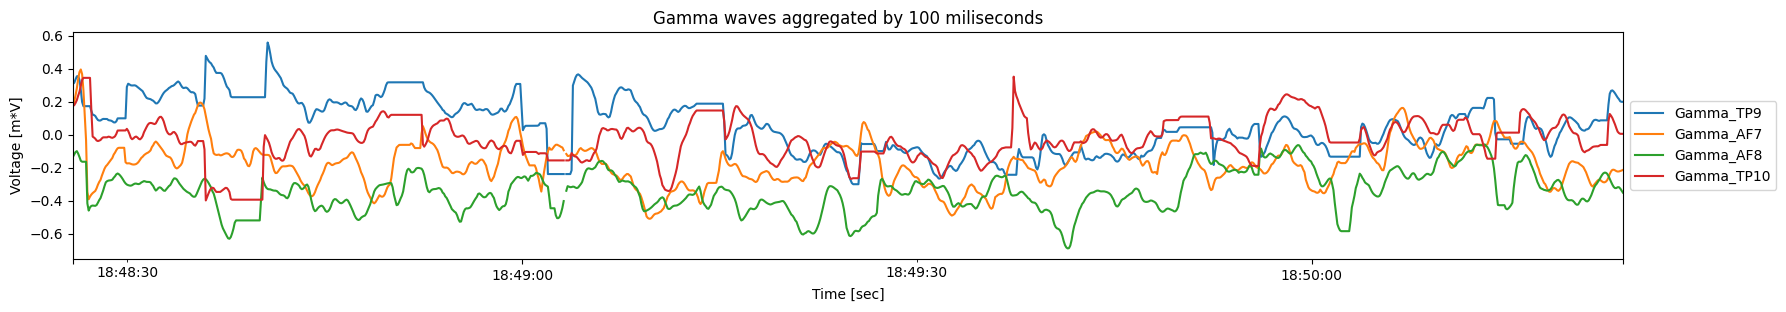

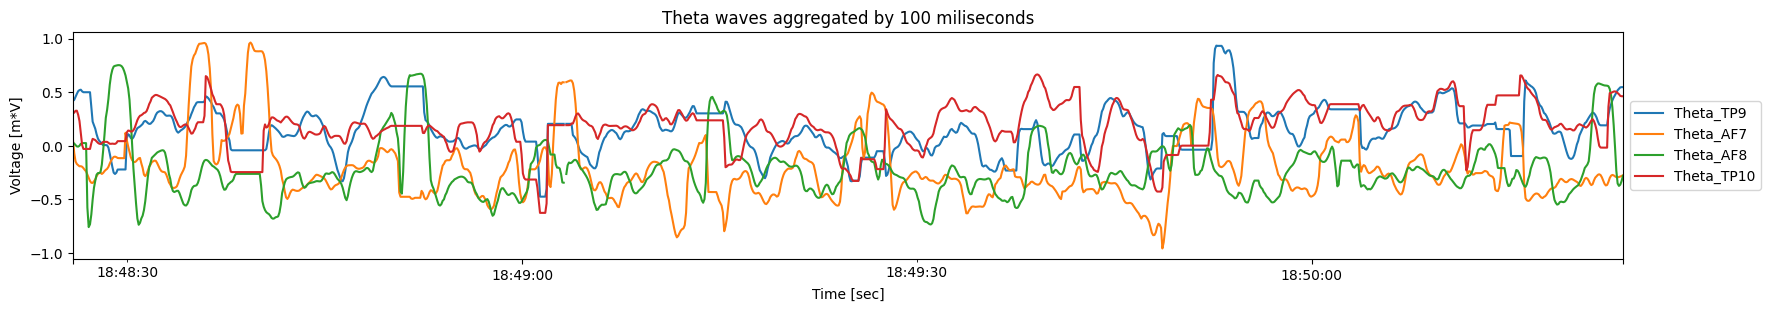

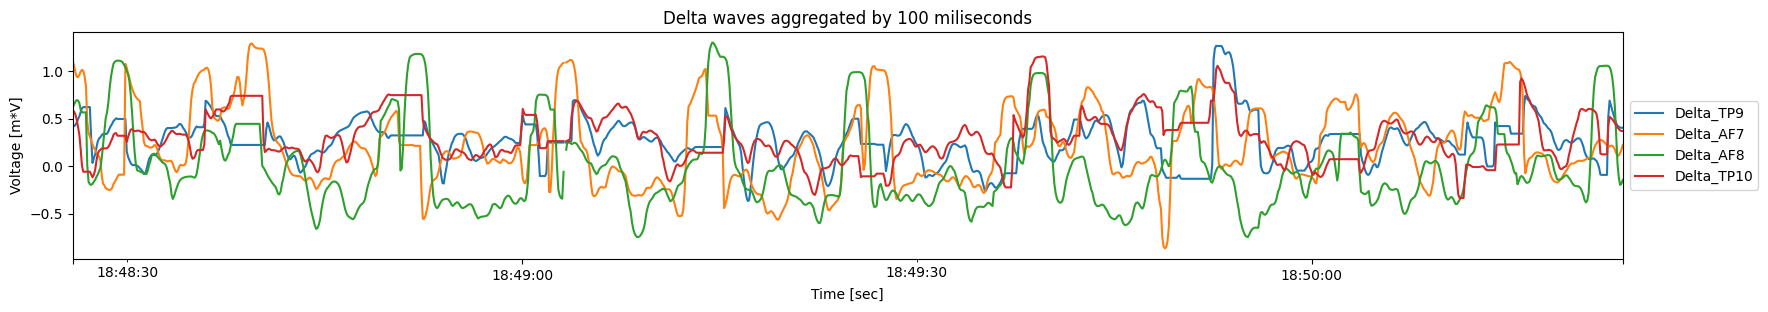

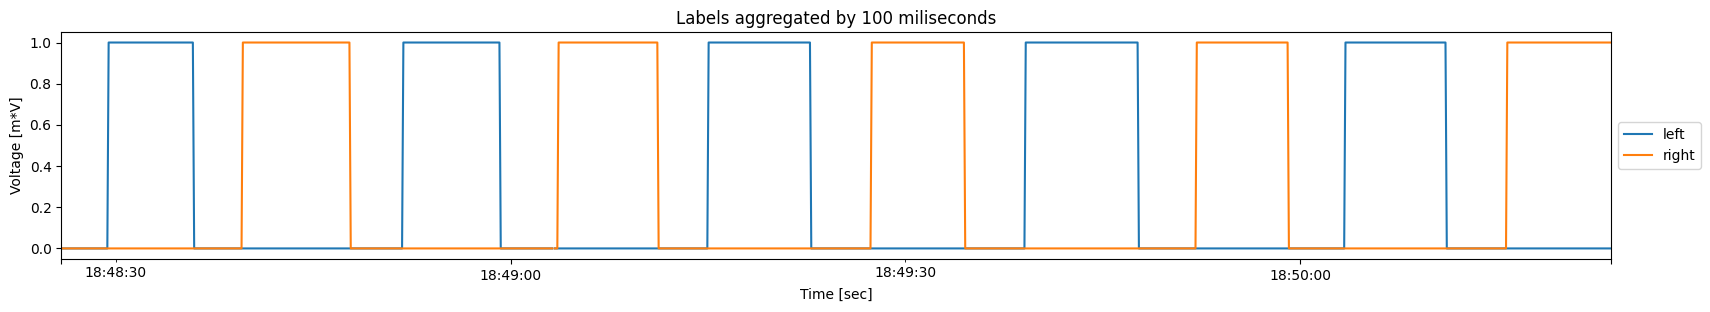

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--18-48-25_5428895603401473874.csv


/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


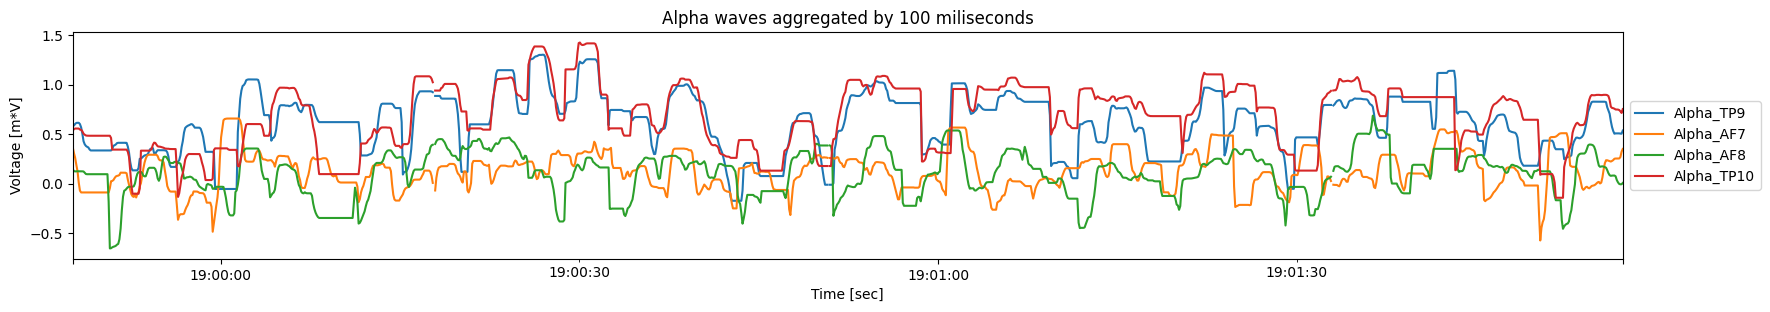

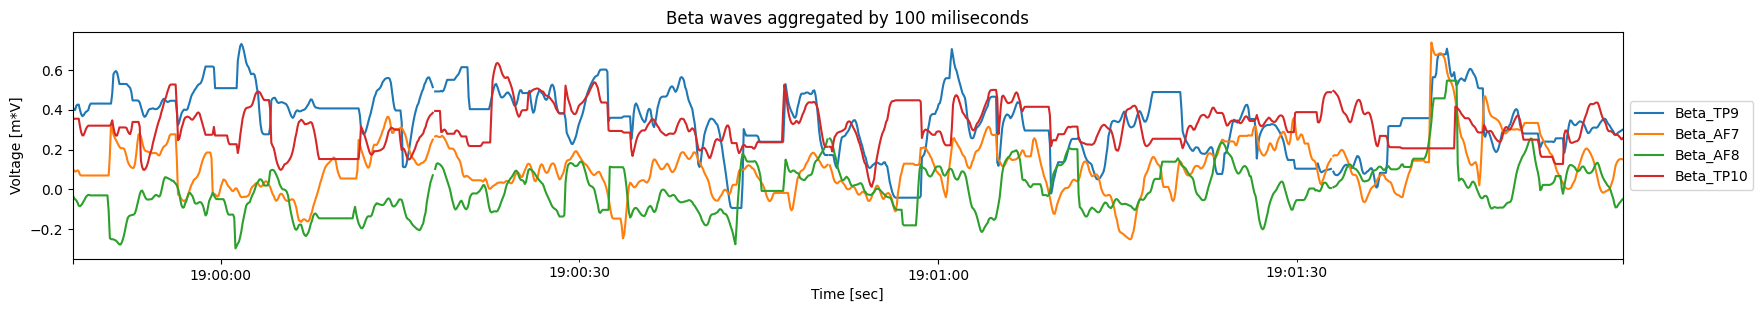

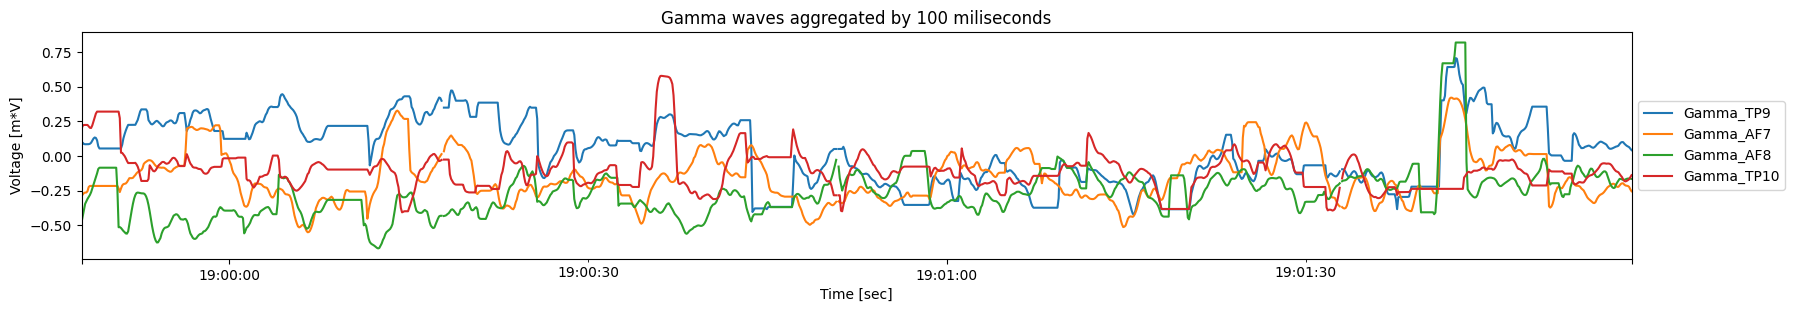

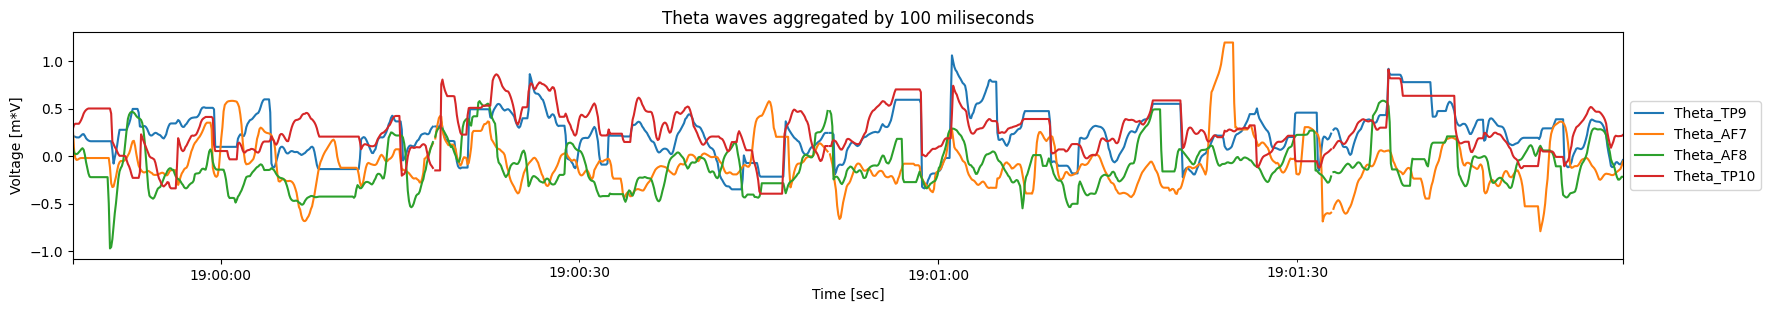

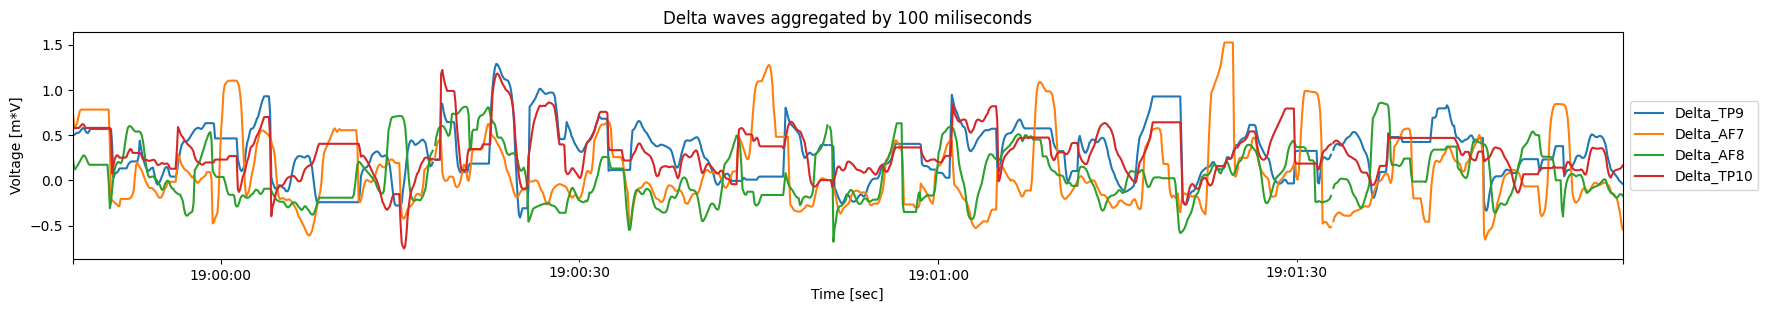

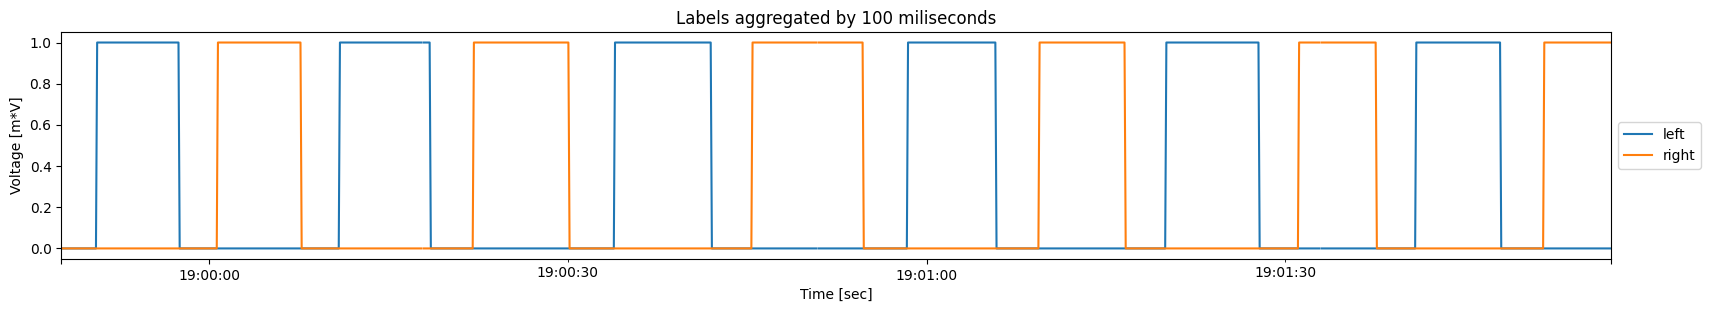

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--18-59-47_3499085155498433131.csv


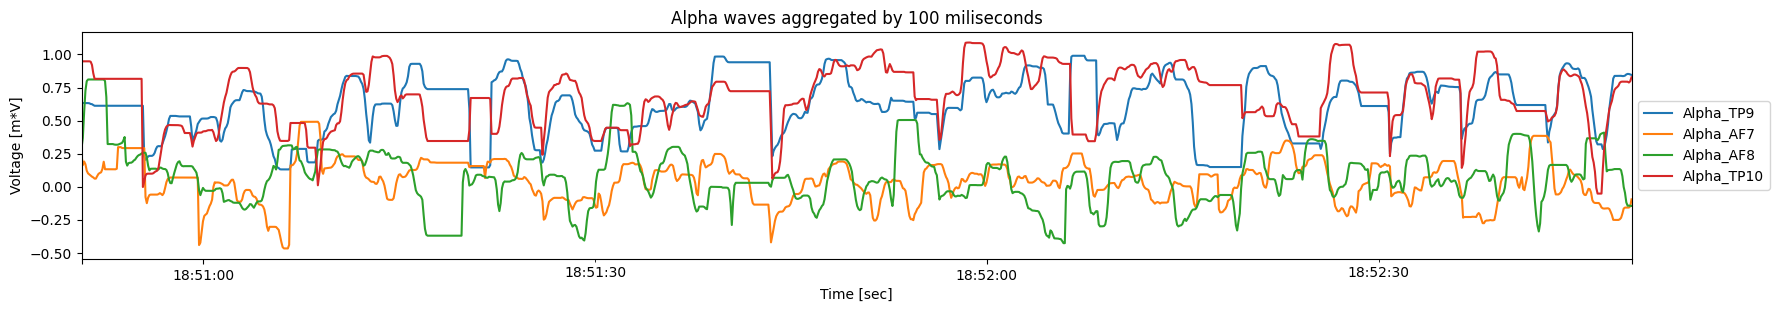

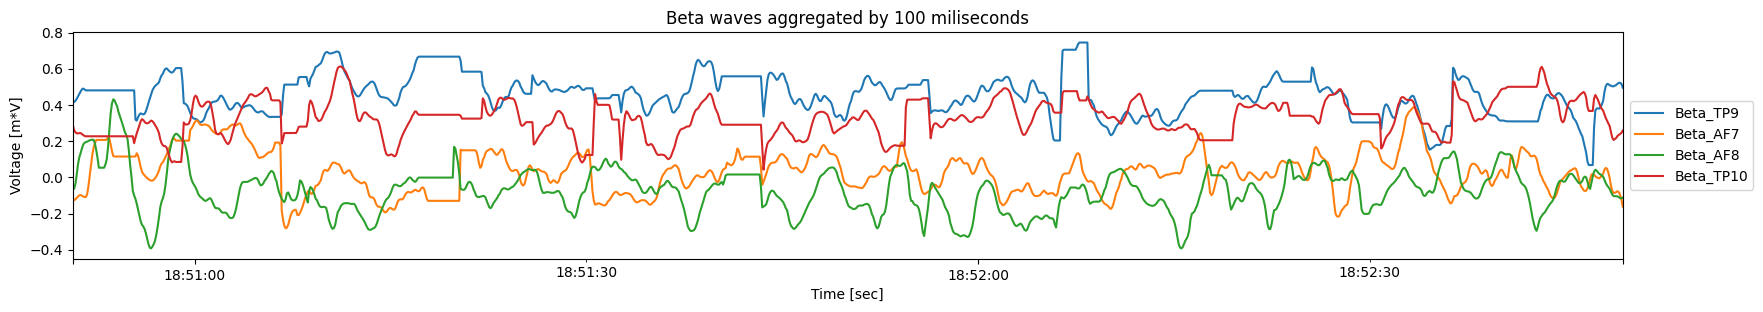

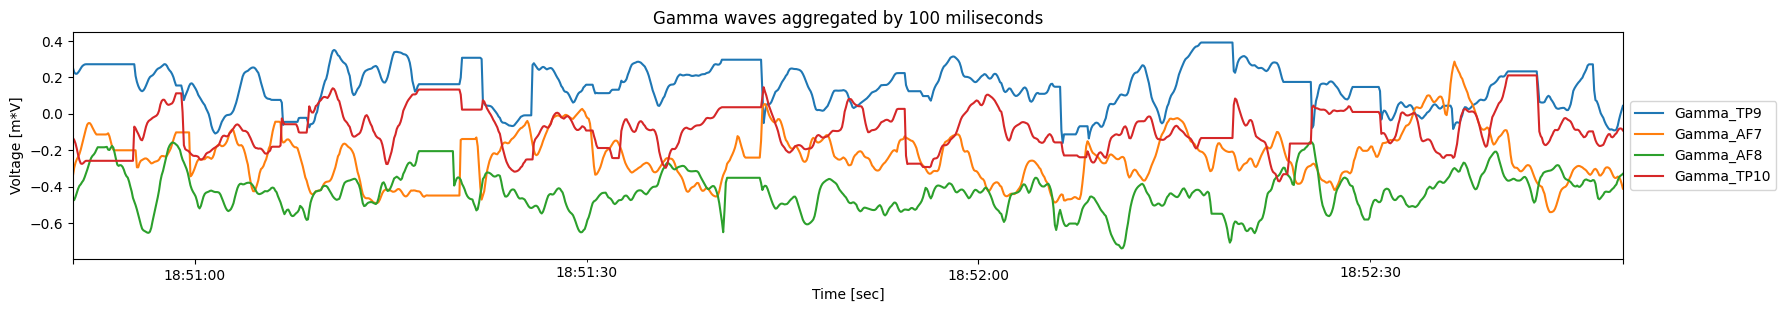

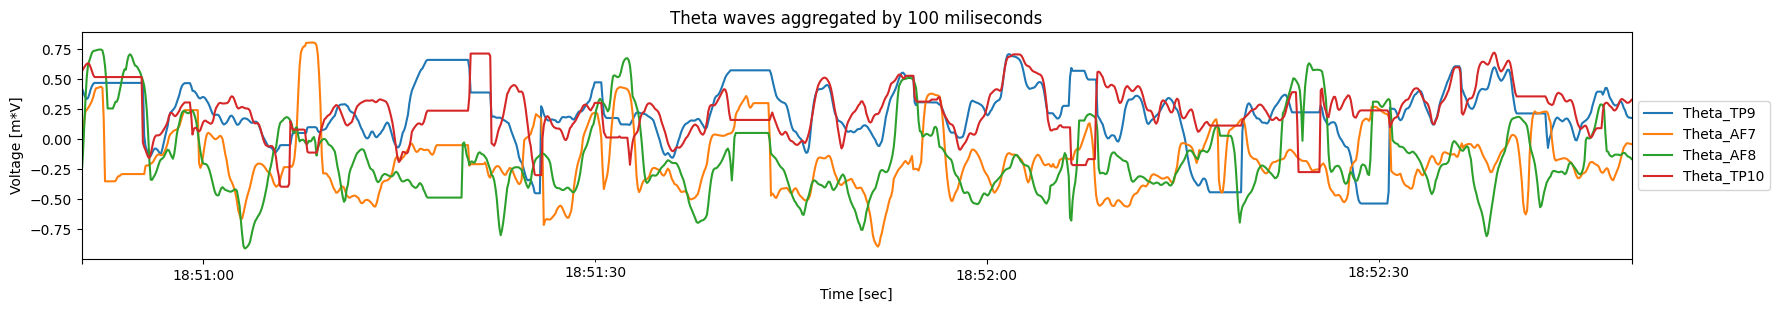

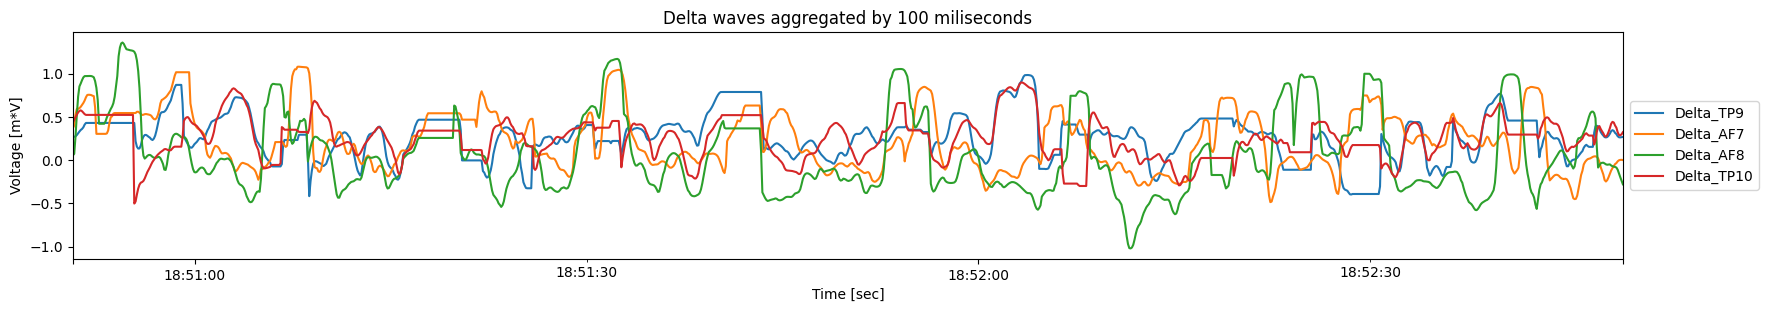

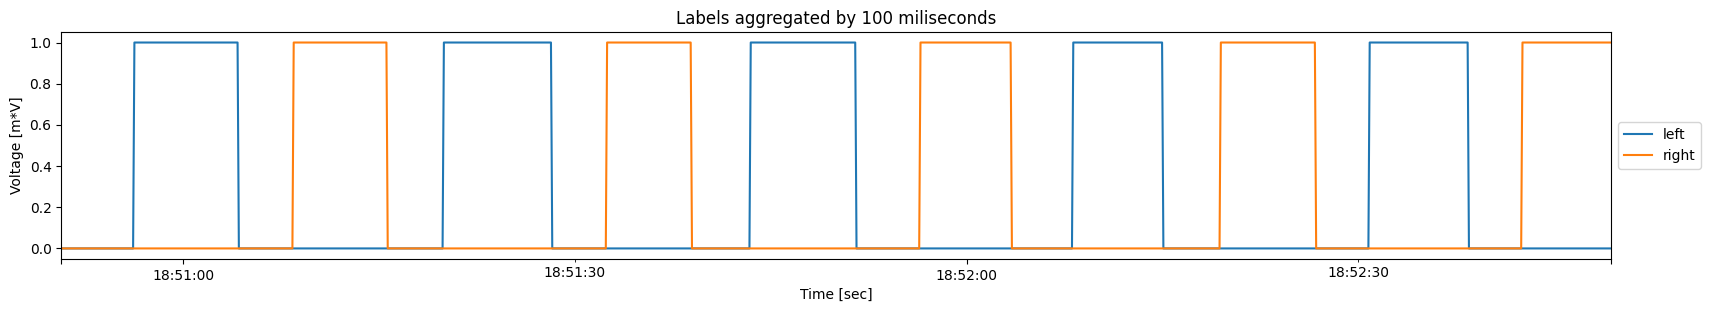

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--18-50-50_1825578246933324357.csv


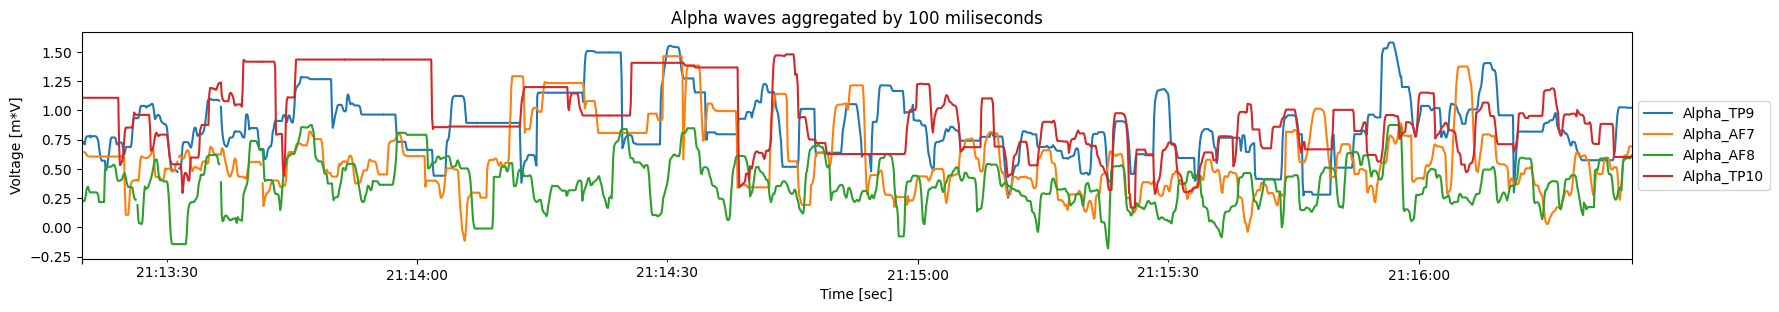

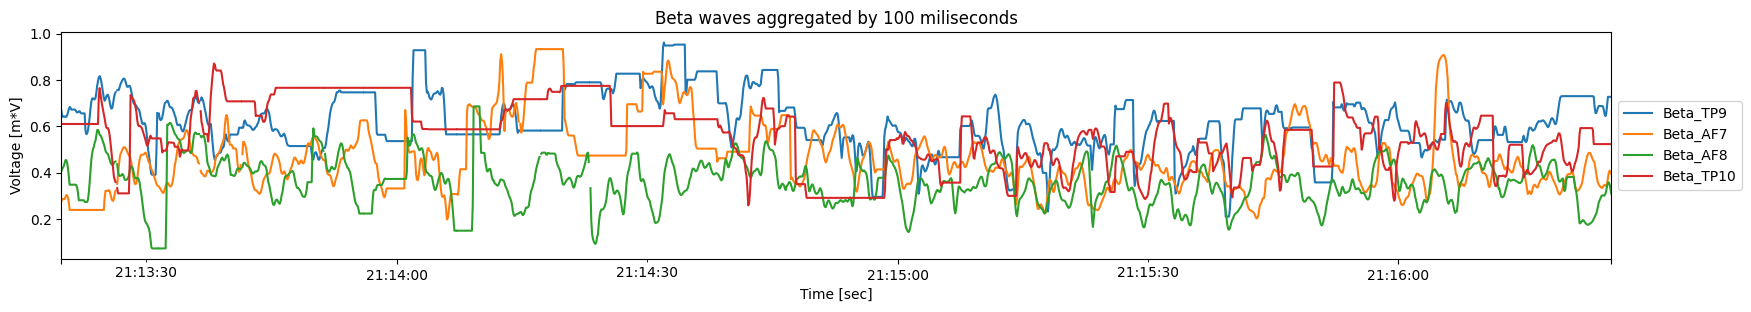

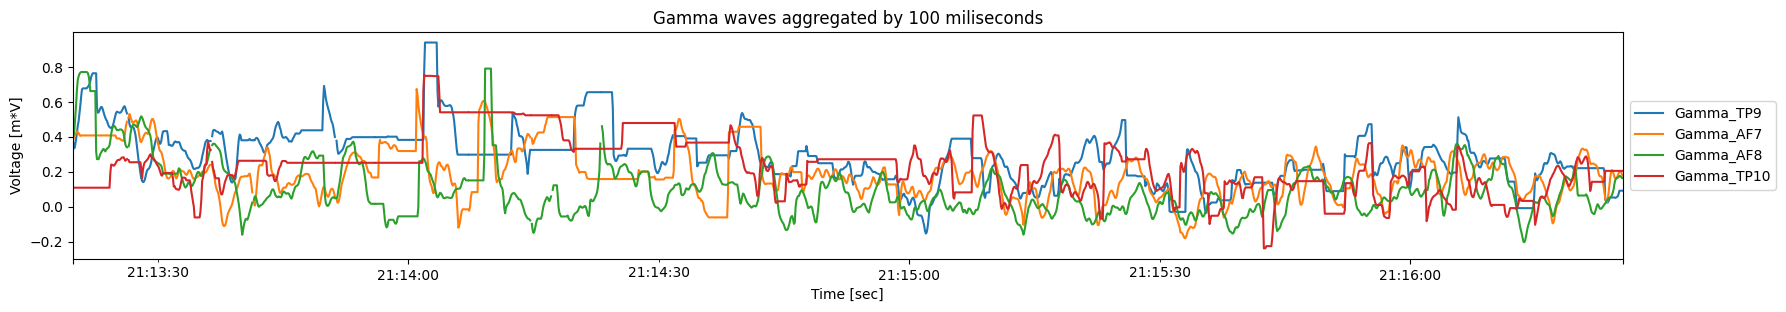

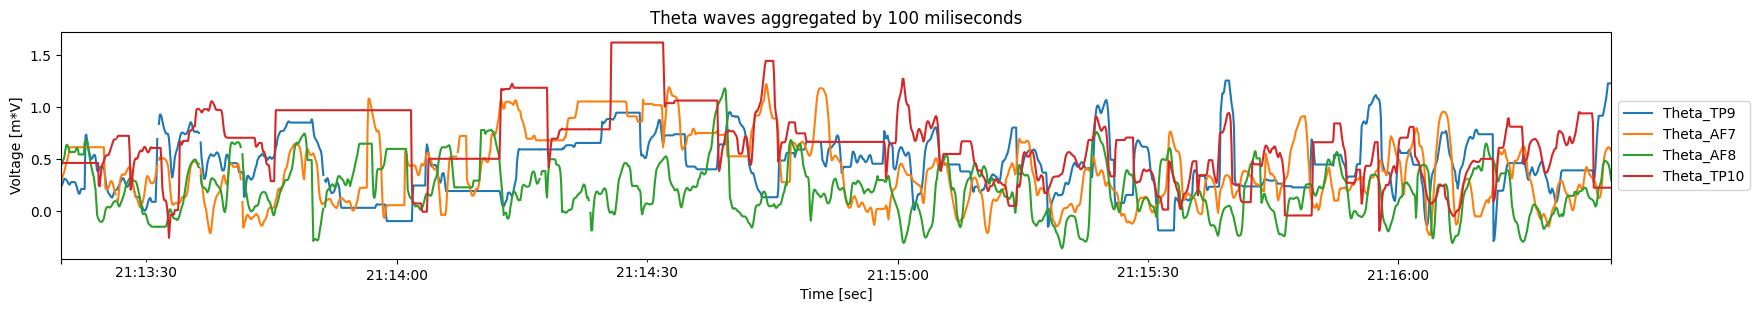

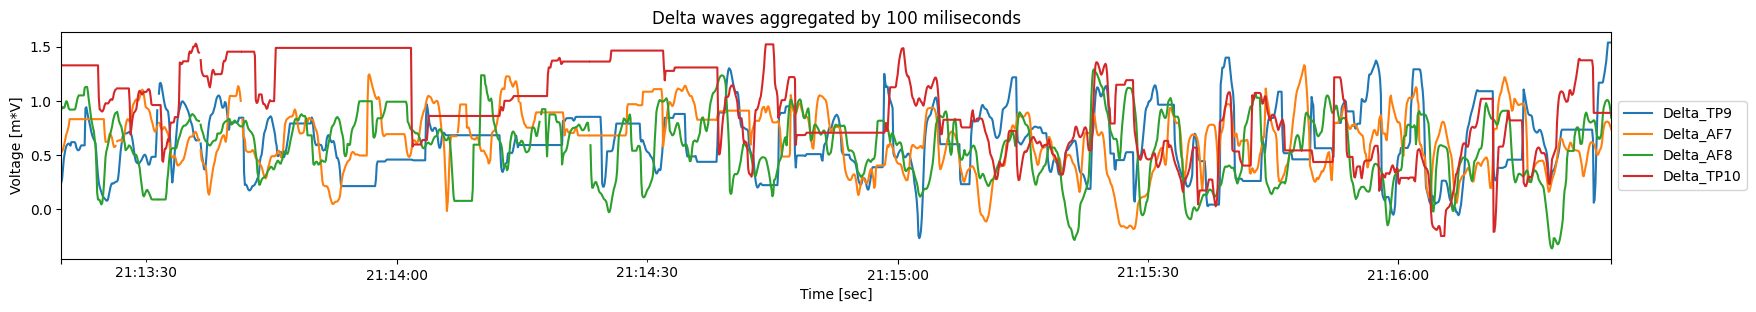

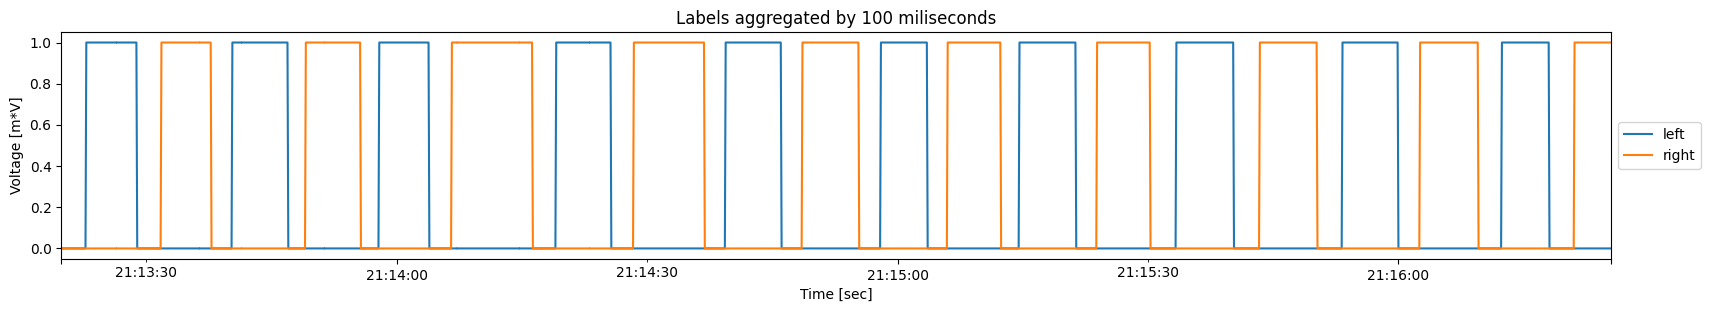

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--21-13-19_5003057843969271283.csv


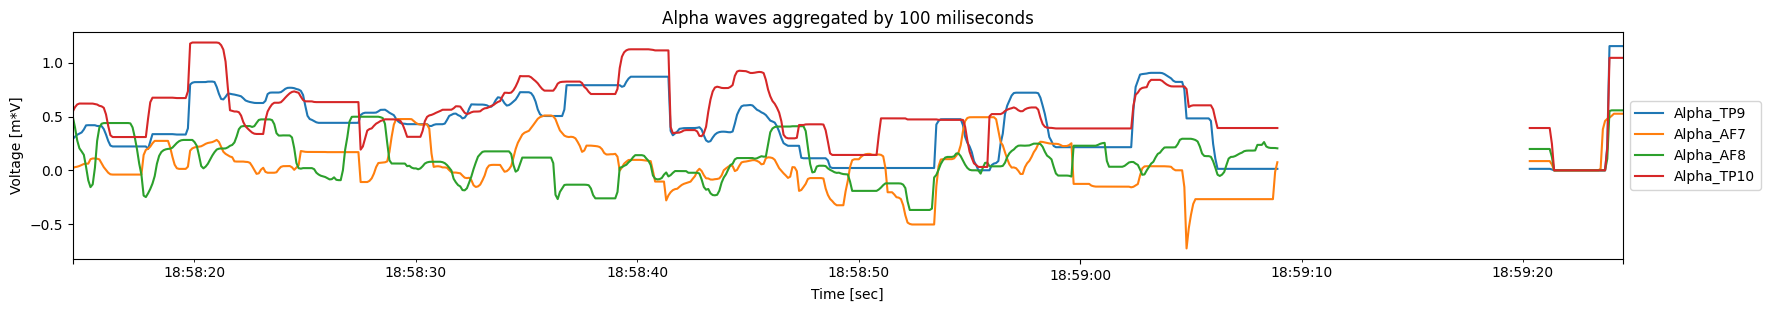

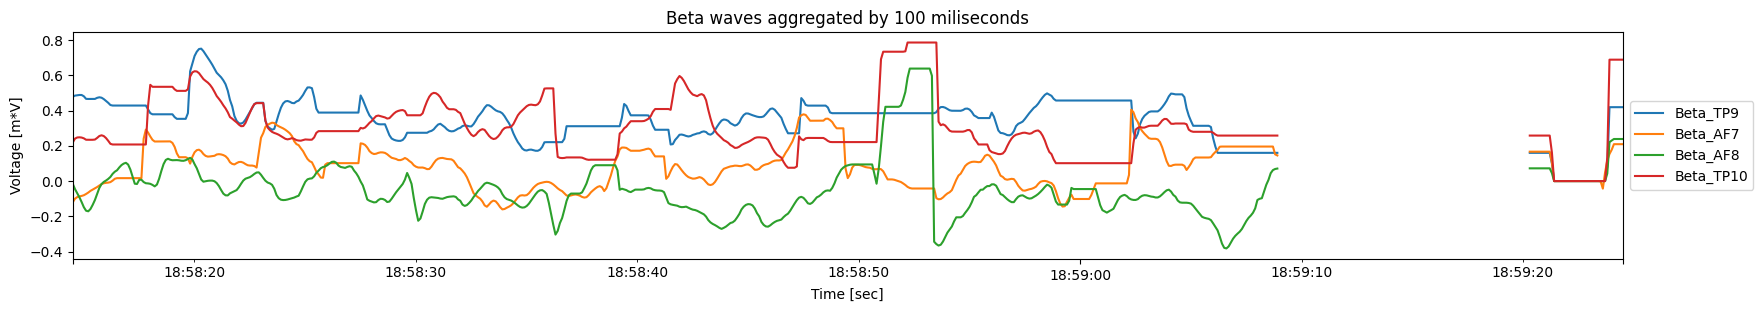

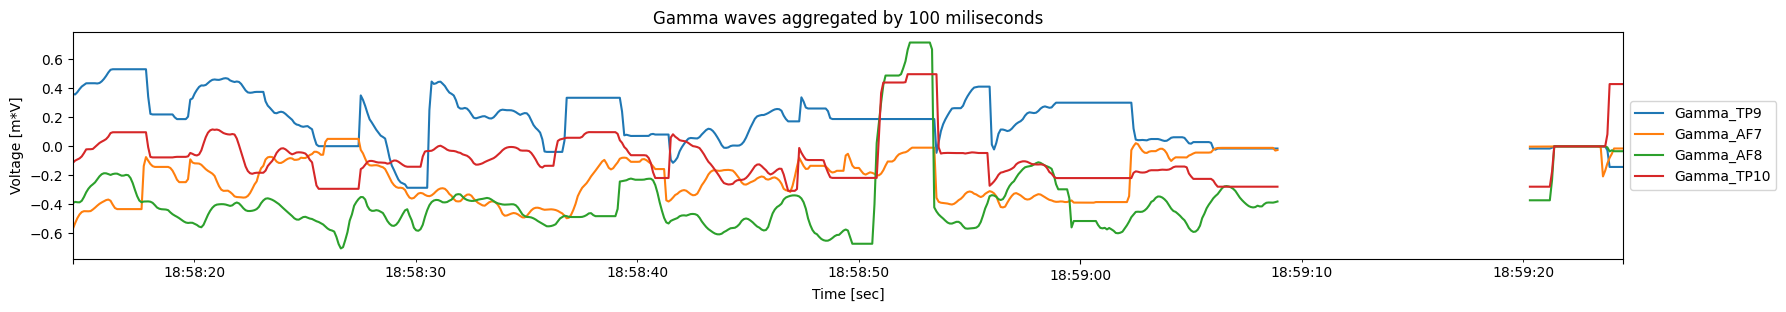

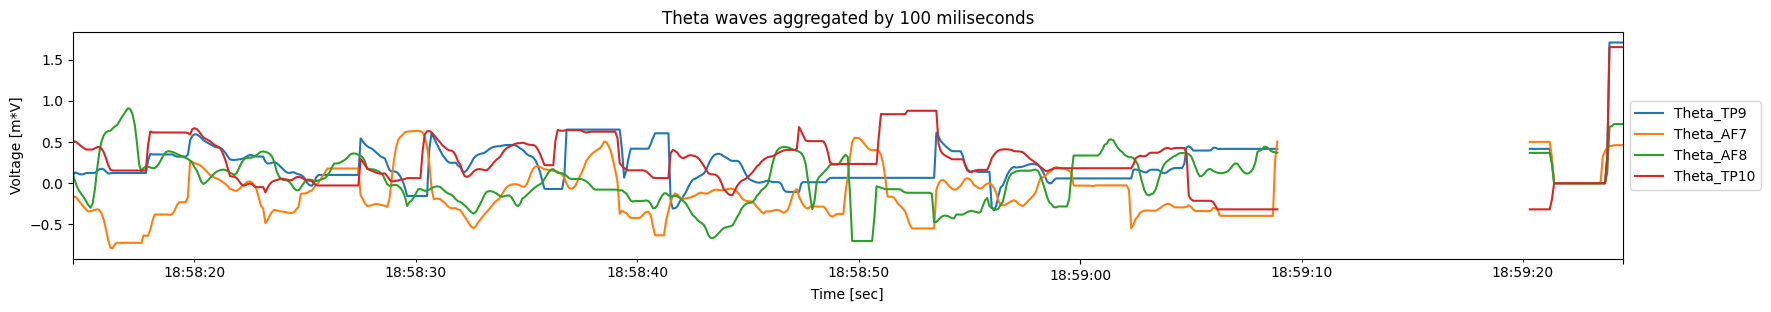

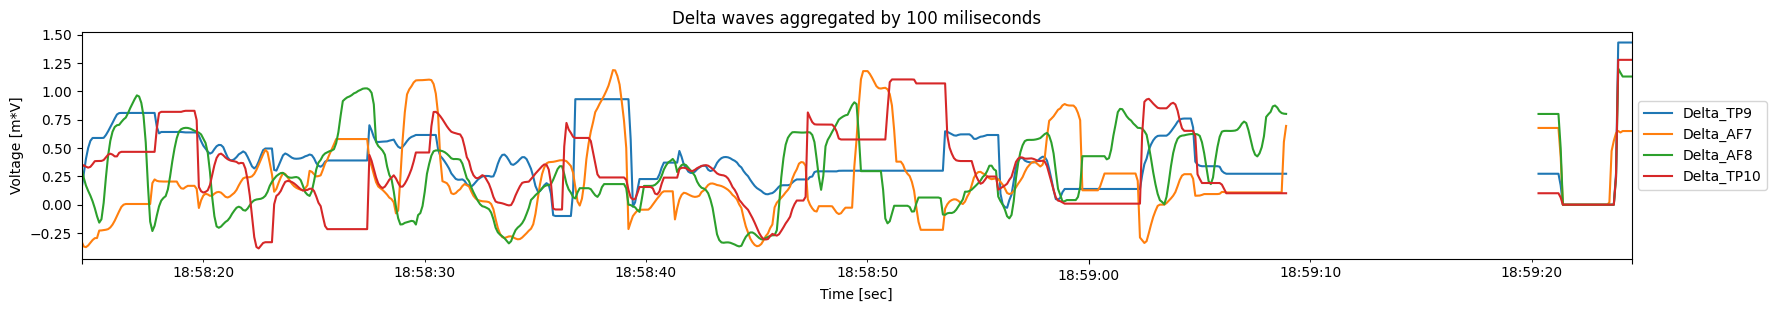

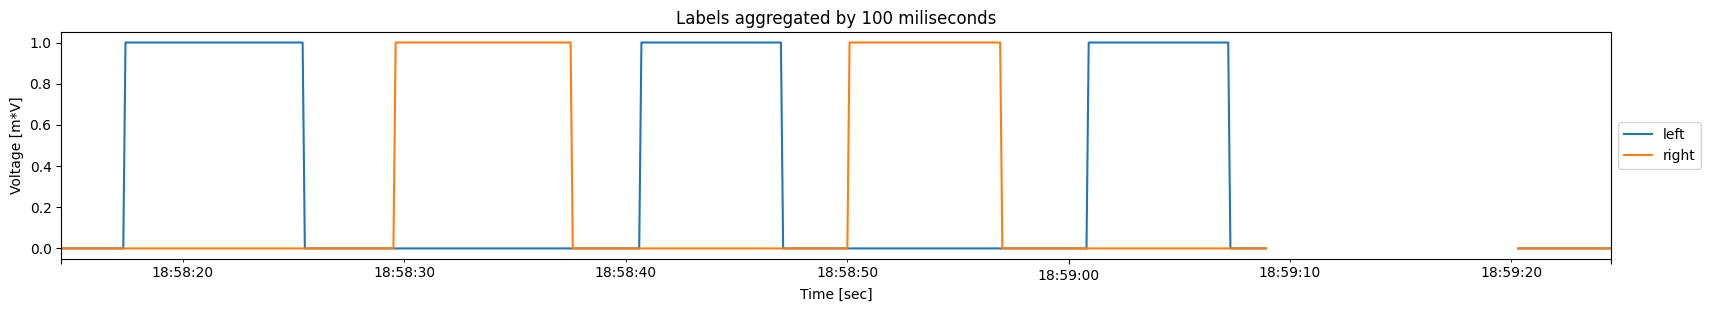

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--18-58-14_5014239148325750123.csv


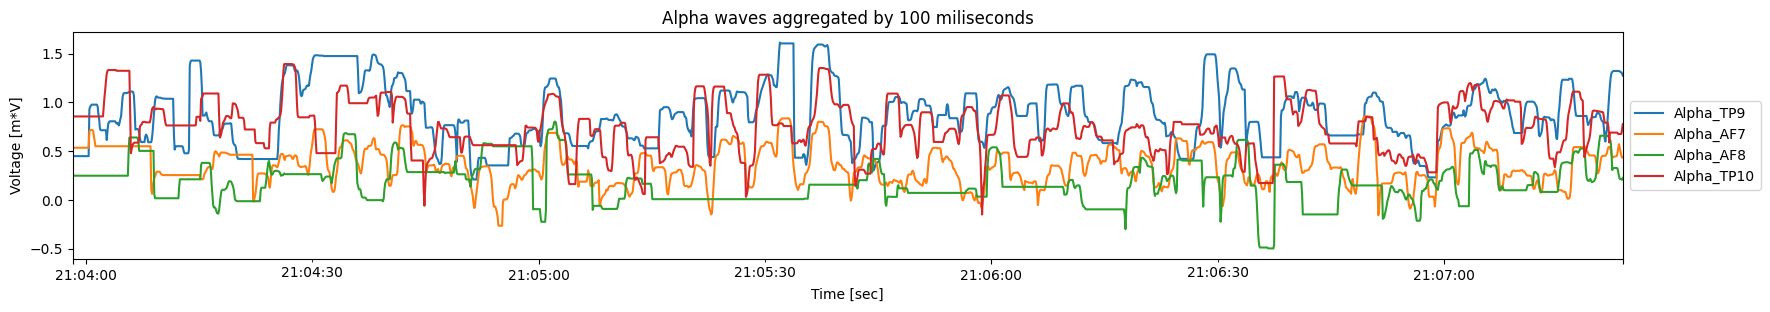

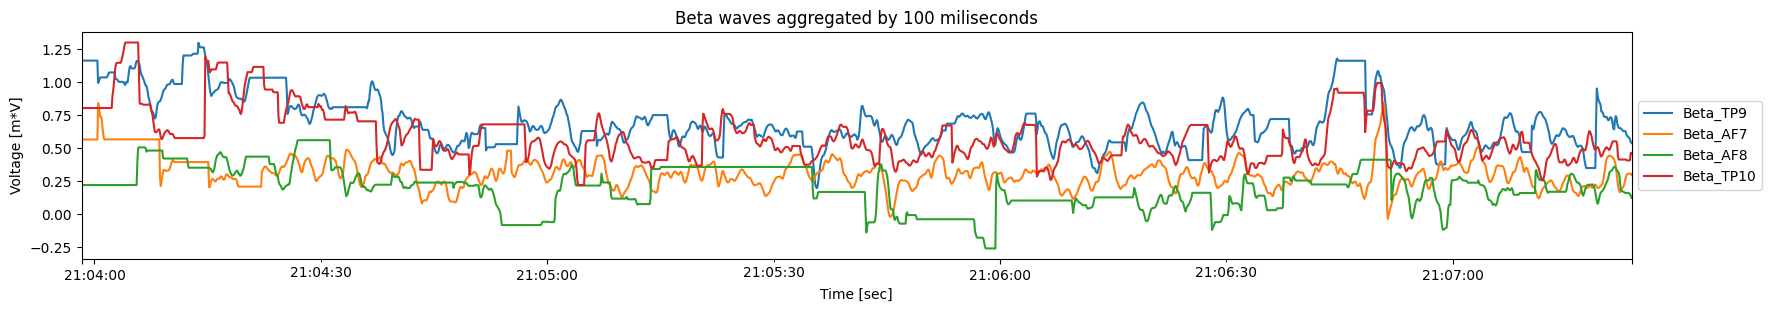

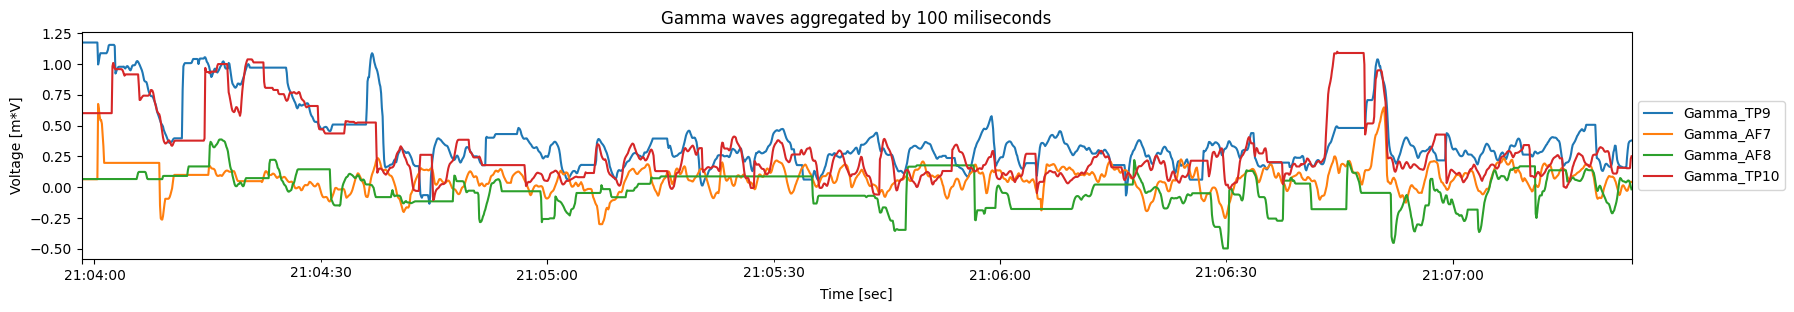

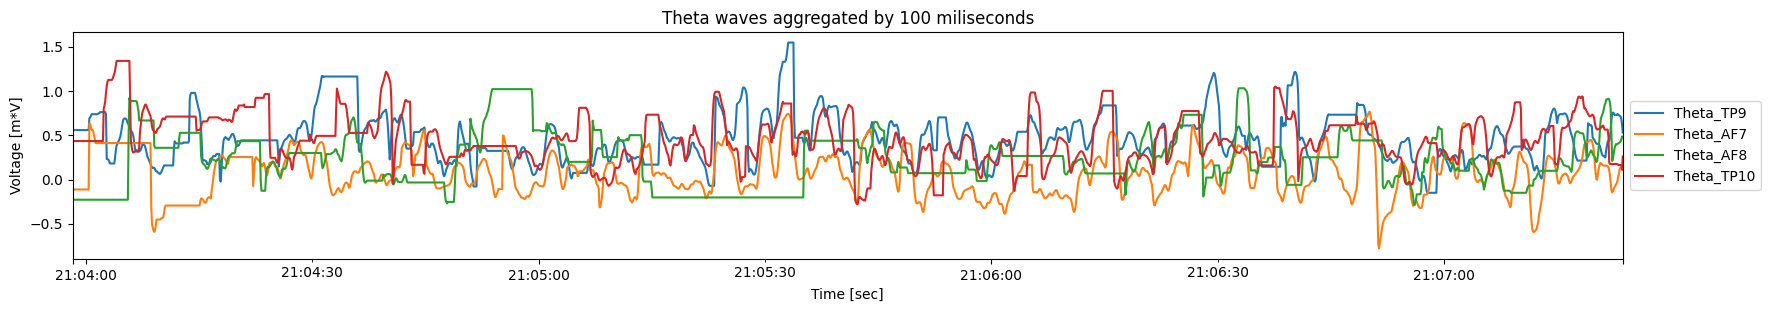

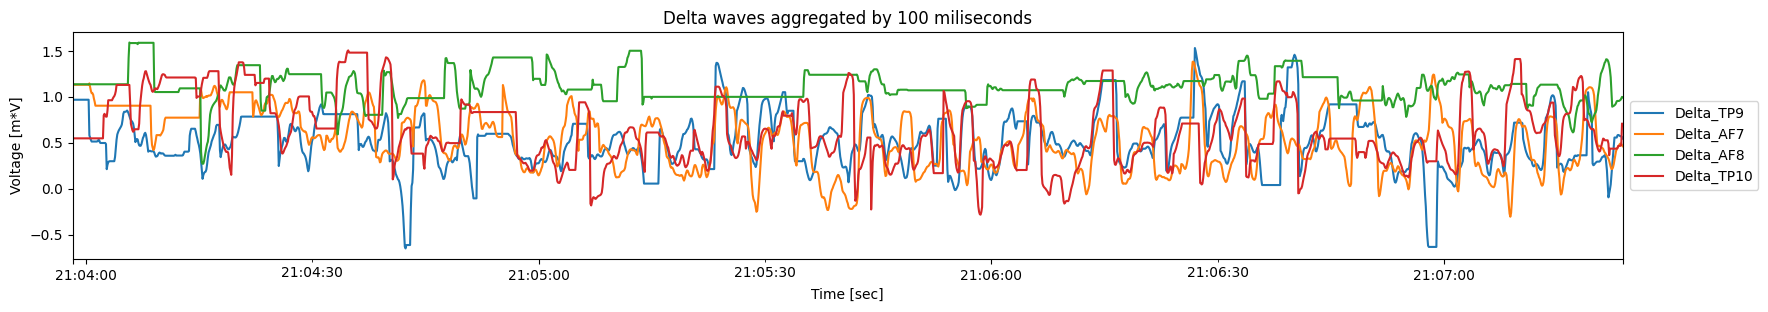

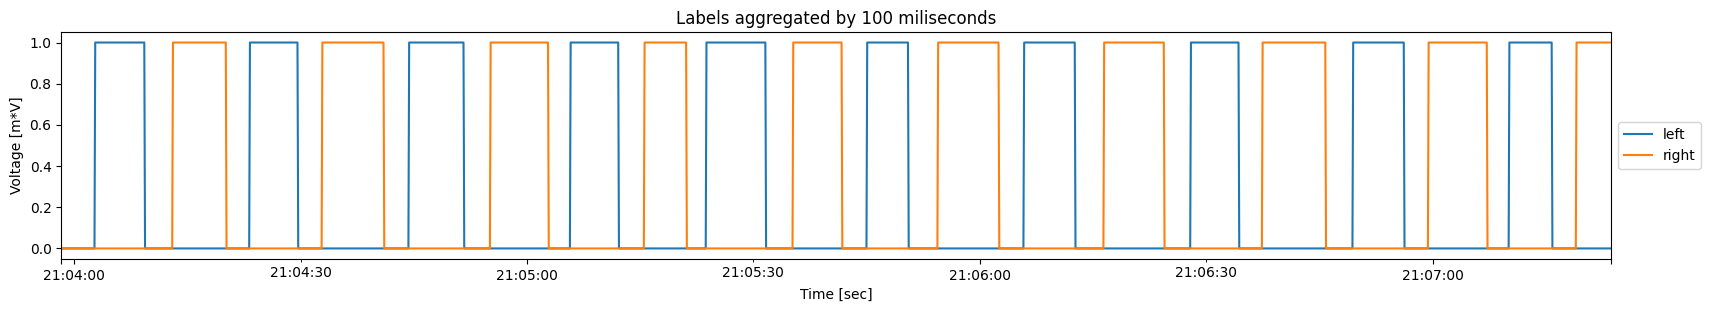

Saved into intermediate_datafiles/motor_imagery/step1_result/med_2021-08-26--21-03-58_7419762883904244960.csv


KeyError: 2

In [10]:
for instance in os.scandir(FOLDER_PATH):
    instance_path = instance.path
    df_instance = pd.read_csv(instance_path, skipinitialspace=True)
    df_instance.drop(df_instance.columns[21:-1], axis=1, inplace=True)
    
    ### Labels
    left_labels, right_labels = [], []
    label = 0
    labels = []

    df_instance['TimeStamp'] = pd.to_datetime(df_instance['TimeStamp'])
    for i in range(0, len(df_instance.index)):
        i_value = df_instance.loc[i, 'Elements']
        if type(i_value) == str and i_value.startswith('/Marker/'):
            label = int(i_value[-1])
        labels.append(label)
    label_series = pd.Series(labels)
    df = pd.get_dummies(label_series)
    df_instance['left'], df_instance['right'] = df[1], df[2]
    df_instance.dropna(thresh=df_instance.shape[1]-10, axis=0, inplace=True)

    ### Make granularity to aggregate the data
    timestamps = pd.date_range(min(df_instance['TimeStamp']), max(df_instance['TimeStamp']), freq=str(GRANULARITY)+'ms')
    
    df = pd.DataFrame(index=timestamps, columns=df_instance.columns[1:-10])
    for col in df_instance.columns[1:]:
        df[str(col)] = np.nan
    
    for i in range(0, len(df.index)):
        relevant_rows = df_instance[
            (df_instance['TimeStamp'] >= df.index[i]) &
            (df_instance['TimeStamp'] < (df.index[i] +
                                        timedelta(milliseconds=GRANULARITY)))]
        for col in df.columns[:-2]:
            if len(relevant_rows) > 0:
                df.loc[df.index[i], str(col)] = np.average(relevant_rows[col])
            else:
                df.loc[df.index[i], str(col)] = np.nan 

        for col in df.columns[-2:]:
            if len(relevant_rows) > 0:
                df.loc[df.index[i], str(col)] = stats.mode(relevant_rows[col])[0] # so only select the mode, not counts
            else:
                df.loc[df.index[i], str(col)] = np.nan
            
    plot_data_eeg(df)
    
    res_path = Path(str(RESULT_PATH) + '/' + instance.name)
    df.to_csv(res_path)
    print(f'Saved into {res_path}')

# Next step: Feature engineering

In [11]:
RESULT2_PATH = Path('./intermediate_datafiles/motor_imagery/step2_result/')
RESULT2_PATH.mkdir(exist_ok=True, parents=True)

In [ ]:
def mixture_model(df, col, n_components):
    # print('Applying mixture models')
    # Fit a mixture model to our data.
    data = df[df[col].notnull()][col]
    g = GaussianMixture(n_components, max_iter=100, n_init=1)
    reshaped_data = np.array(data.values.reshape(-1, 1))
    g.fit(reshaped_data)
    # Predict the probabilities
    probs = g.score_samples(reshaped_data)

    # Create the right data frame and concatenate the two.
    data_probs = pd.DataFrame(
        np.power(10, probs), index=data.index, columns=[col+'_mixture'])

    df = pd.concat([df, data_probs], axis=1)
    return df

def low_pass_filter(df, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
    amplitude = 0.5
    nyq = amplitude * sampling_frequency
    normal_cutoff = cutoff_frequency / nyq

    b, a = butter(order, normal_cutoff, btype='low', output='ba', analog=False)
    if phase_shift:
        df[col + '_lowpass'] = filtfilt(b, a, df[col])
    else:
        df[col + '_lowpass'] = lfilter(b, a, df[col])
    return df

def aggregate_value(data, window_size, aggregation_function):
    def get_slope(data):      
        times = np.array(range(0, len(data.index)))
        data = data.astype(np.float32)
        mask = ~np.isnan(data)
        if (len(data[mask]) == 0):
            return np.nan
        else:
            slope, _, _, _, _ = stats.linregress(times[mask], data[mask])
            return slope
    
    window = str(window_size) + 's'
    if aggregation_function == 'mean':
        return data.rolling(window, min_periods=window_size).mean()
    elif aggregation_function == 'max':
        return data.rolling(window, min_periods=window_size).max()
    elif aggregation_function == 'min':
        return data.rolling(window, min_periods=window_size).min()
    elif aggregation_function == 'median':
        return data.rolling(window, min_periods=window_size).median()
    elif aggregation_function == 'std':
        return data.rolling(window, min_periods=window_size).std()
    elif aggregation_function == 'slope':
        return data.rolling(window, min_periods=window_size).apply(get_slope)
    else:
        return np.nan
    
def find_fft_transformation(df):
    transformation = np.fft.rfft(df, len(df))
    real_ampl = transformation.real
    max_freq = freqs[np.argmax(real_ampl[0:len(real_ampl)])]
    freq_weigthed = float(np.sum(freqs * real_ampl)) / np.sum(real_ampl)

    PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
    PSD_pdf = np.divide(PSD, np.sum(PSD))

    if np.count_nonzero(PSD_pdf) == PSD_pdf.size:
        pse = -np.sum(np.log(PSD_pdf) * PSD_pdf)
    else:
        pse = 0

    real_ampl = np.insert(real_ampl, 0, max_freq)
    real_ampl = np.insert(real_ampl, 0, freq_weigthed)
    row = np.insert(real_ampl, 0, pse)
    temp_list.append(row)
    return 0


for instance in os.scandir(RESULT_PATH): # go through all instances of experiments  
    result_instance_path = instance.path
    try:
        df = pd.read_csv(result_instance_path, index_col=0)
    except IsADirectoryError:
        print('file of not csv exantion')
        continue
    df.index = pd.to_datetime(df.index)

    for col in df.columns[:-2]:
        try:
            df = mixture_model(df, col, 3)
        except ValueError:
            continue

        df.loc[df[f'{col}_mixture'] < 0.0005, col] = np.nan
        del df[col + '_mixture']

        df[col] = df[col].interpolate() #interpolating missing values
        df[col] = df[col].fillna(method='bfill') # And fill the initial data points if needed

        # check if all nan are filled in
        # print('Check, number of nans left should be 0: ' + str(df[col].isna().sum()))
        fs, cutoff = 30, 2
        df = low_pass_filter(df, col, fs, cutoff, order=10)
        df[col] = df[col + '_lowpass']
        del df[col + '_lowpass']
    
    ### Features
    ### PCA
    n_pcs = 4
    df2 = copy.deepcopy(df)
    cols = df2.columns[:-3]

    df_norm = copy.deepcopy(df2)
    for col in cols:
        df_norm[col] = (df2[col] - df2[col].mean()) / (df2[col].max() - df2[col].min())

    pca = PCA(n_components=n_pcs)
    try:
        pca.fit(df_norm[cols])
    except ValueError:
        continue
        print('The end of the dataset.')
        
    new_values = pca.transform(df_norm[cols])

    for comp in range(0, n_pcs):
        df2['pca_' +str(comp+1)] = new_values[:,comp]
        
    ### ICA
    cols = df2.columns[:-7]
    df_norm = copy.deepcopy(df2)

    # perform the FastICA for all components.
    ica = FastICA(n_components=len(cols))
    ica.fit(df_norm[cols])
    new_values = ica.transform(df_norm[cols])
    for comp in range(0, len(cols)):
        df2['FastICA_' +str(comp+1)] = new_values[:,comp]
        
    ### Fourier transformation
    milliseconds_per_instance = (df_norm.index[1] - df_norm.index[0]).microseconds/1000
    ws = int(float(1000)/milliseconds_per_instance)
    fs = 100 # sample frequency
    freqs = (fs * np.fft.rfftfreq(int(ws))).round(3)
    
    for agg in ['mean', 'std', 'max', 'min', 'median', 'slope']:
        for col in cols:                   
            df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
    
    for col in cols:
        temp_list, frequencies = [], []
        collist = []
        collist.append(col + '_max_freq_ws_' + str(ws))
        collist.append(col + '_freq_weighted_ws_' + str(ws))
        collist.append(col + '_pse_ws_' + str(ws))
        collist = collist + [col + '_freq_' + str(freq) + '_Hz_ws_' + str(ws) for freq in freqs]

        # rolling statistics to calculate frequencies, per window size. 
        # Pandas Rolling method can only return one aggregation value. 
        # Therefore values are not returned but stored in temp class variable 'temp_list'.
        df2[col].rolling(ws + 1).apply(find_fft_transformation)

        # Pad the missing rows with nans
        frequencies = np.pad(np.array(temp_list), ((ws, 0), (0, 0)), 'constant', constant_values=np.nan)

        # add new freq columns to frame
        df2[collist] = pd.DataFrame(frequencies, index=df2.index)
    
    window_overlap = 0.5
    # we do this for the biggest ws
    skip_points = int((1-window_overlap) * ws)
    df2 = df2.iloc[::skip_points,:]

    #apparently the first two rows are NaNs so delete those.
    df2 = df2.iloc[2:]
    
    res2_path = Path(str(RESULT2_PATH) + '/' + instance.name)
    df2.to_csv(res2_path)
    print(f'Saved into {res2_path}')

print('done.')

/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--18-45-49_174012250194033688.csv


/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--21-11-50_6232541803114330650.csv


/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--18-48-25_5428895603401473874.csv


/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--18-59-47_3499085155498433131.csv


/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--18-50-50_1825578246933324357.csv


/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--21-13-19_5003057843969271283.csv


/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

Saved into intermediate_datafiles/motor_imagery/step2_result/med_2021-08-26--18-58-14_5014239148325750123.csv


/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/var/folders/gd/2tcvq2ss7390zpx1fn2lfry40000gn/T/ipykernel_11152/794218578.py:147: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[col + '_temp_' + agg + '_ws_' + str(ws)] = aggregate_value(df2[col], ws, agg)
/Users/sofiapetryshyn/opt/anaconda3/envs/eeg/lib/python3.10/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins